## Reference guides:
https://realpython.com/python-web-scraping-practical-introduction/  
https://realpython.com/beautiful-soup-web-scraper-python/

## Real world test:
https://ai-jobs.net/

In [1]:
import re
import time
import requests
import numpy as np

from bs4 import BeautifulSoup
from collections import Counter
from selenium import webdriver

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
url = 'https://ai-jobs.net/'

In [3]:
## launch headless Edge instance
options = webdriver.EdgeOptions()
options.add_argument('--headless')

driver = webdriver.Edge(options = options)
driver.get(url)

## grab html from page
page = driver.page_source.encode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

## find total number of jobs found
job_count_ele = soup.find('em', id = 'job-search-count')
job_count = int(re.search(r'[0-9]+(?= jobs)', str(job_count_ele)).group())

In [4]:
## click 'load more' button to load all jobs
for i in range((job_count // 100)):
    button = driver.find_element('id', 'load-more-jobs')
    driver.execute_script('arguments[0].click()', button)
    time.sleep(1)
    if i % 10 == 0:
        print('Progress: ' + str(i) + ' clicks')

Progress: 0 clicks
Progress: 10 clicks
Progress: 20 clicks
Progress: 30 clicks


In [5]:
## recapture html from page with all jobs loaded. Grab all jobs listings as rows
page = driver.page_source.encode('utf-8')
soup = BeautifulSoup(page, 'html.parser')
job_rows = soup.find_all('a', class_ = 'col pt-2 pb-3')

In [7]:
## initiate variables for loop
df = pd.DataFrame(columns = ['url','description', 'pay_level', 'tags', 'perks', 'location'])
words = []
counter = 0
start = time.time()

## loop through rows, grabbing unique job posting url from each  
for i in range(len(job_rows)):
    
    ## grab url for unique job post
    job_link = re.search(r'(?<=href=\").*(?=\" title)', str(job_rows[i])).group()
    job_url = str(url + 
                  re.search(r'(?<=href=\").*(?=\" title)', 
                            str(job_rows[i])).group()
                 )
    
    ## capture html from post page
    job_page = requests.get(job_url)
    job_soup = BeautifulSoup(job_page.content, 'html.parser')
    
    ## grab job description
    job_descr = job_soup.find('div', id = 'job-description')
    job_descr = re.sub(r'\<.*\>', '', job_descr.prettify())
    
    ## grab element with detials on pay, seniority, full/part-time status
    pay_level = job_soup.find('div', class_ = 'col-6 col-sm-7').get_text()
    
    ## grab all tag elements, and loop through to isolate text
    tags = job_soup.find_all('a', title = re.compile(r'Find more jobs related .*'))
    tags_list = []
    for tag in tags:
        tags_list.append(tag.string)
    
    ## grab all perk elements, and loop through to isolate text
    perks = job_soup.find_all('a', title = re.compile(r'Find more jobs with .*'))
    perks_list = []
    for perk in perks:
        perks_list.append(perk.string)
    
    ## try to grab location, if it exists for post
    location = np.nan
    try:
        location = job_soup.find('a', title = re.compile(r'Find more .* jobs in .*')).string
    except:
        pass
    
    ## move all variables to dataframe
    df.loc[i,'url'] = job_url
    df.loc[i,'description'] = ' '.join(job_descr.split())
    df.loc[i,'pay_level'] = '; '.join(re.sub('\n\n', '', pay_level).split('\n'))
    df.loc[i,'tags'] = '; '.join(tags_list)
    df.loc[i,'perks'] = '; '.join(perks_list)
    df.loc[i,'location'] = location
    
    ## move tokenized words from job description to word list
    words.append(re.sub(r'[.,!?:;\"\'\’-]', '', job_descr.lower()).split())
    
    ## check progress
    counter += 1
    if counter % 250 == 0:
        print('Progress: ' + str(counter) + ' of ' + 
              str(len(job_rows)) + '. Time Elapsed: ' + 
              '{:0>2}:{:0>2}'.format(int((time.time()-start)//60),
                                     int((time.time()-start)%60))
             )

Progress: 250 of 3968. Time Elapsed: 02:01
Progress: 500 of 3968. Time Elapsed: 04:04
Progress: 750 of 3968. Time Elapsed: 06:06
Progress: 1000 of 3968. Time Elapsed: 08:08
Progress: 1250 of 3968. Time Elapsed: 10:11
Progress: 1500 of 3968. Time Elapsed: 12:14
Progress: 1750 of 3968. Time Elapsed: 14:18
Progress: 2000 of 3968. Time Elapsed: 16:20
Progress: 2250 of 3968. Time Elapsed: 18:25
Progress: 2500 of 3968. Time Elapsed: 20:27
Progress: 2750 of 3968. Time Elapsed: 22:30
Progress: 3000 of 3968. Time Elapsed: 24:35
Progress: 3250 of 3968. Time Elapsed: 26:37
Progress: 3500 of 3968. Time Elapsed: 28:43
Progress: 3750 of 3968. Time Elapsed: 30:46


In [8]:
df

,url,description,pay_level,tags,perks,location
0,https://ai-jobs.net//job/40879-data-analyst/,Neon is an open-source company on a mission to...,Full Time; Senior-level / Expert; USD 80K - 110K,A/B testing; Data Analytics; Data Studio; Data...,Competitive pay; Equity,NaN
1,https://ai-jobs.net//job/40788-ai-application-...,Are you a creative AI Application Developer wi...,Freelance; USD 20K - 30K,Chatbots; ChatGPT; GPT; Research,,NaN
2,https://ai-jobs.net//job/40787-ai-content-crea...,Are you a creative AI Content Creator with dom...,Freelance; USD 20K - 30K,AI content; Anyword; Marketmuse; Research; Wor...,,NaN
3,https://ai-jobs.net//job/40786-ai-video-producer/,Are you a creative AI Video Producer with doma...,Freelance; USD 20K - 30K,AI video; Pictory; Research,,NaN
4,https://ai-jobs.net//job/40785-ai-artist/,Are you a creative AI Artist with domain exper...,Freelance; USD 20K - 30K,AI art; DALL-E; Midjourney; Research; Stable D...,,NaN
...,...,...,...,...,...,...
3963,https://ai-jobs.net//job/37066-data-engineer-d...,We are seeking a Data Engineer with 3+ years o...,Full Time; Mid-level / Intermediate; USD 73K -...,BigQuery; Data analysis; Data pipelines; Kafka...,Career development; Flex hours; Gear; Team events,Pakistan
3964,https://ai-jobs.net//job/37023-data-architect-...,The Opportunity MMT have partnered with a lead...,Full Time; Contract; Mid-level / Intermediate;...,Airflow; Azure; CI/CD; Databricks; Data Wareho...,Flex vacation,United Kingdom
3965,https://ai-jobs.net//job/37037-data-scientist-...,Credit Key’s mission is to deliver a superior ...,Full Time; Entry-level / Junior; USD 36K - 90K *,A/B testing; Data analysis; E-commerce; Financ...,401(k) matching; Cell phone stipend; Competiti...,United States
3966,https://ai-jobs.net//job/37047-data-analyst/,Company Description About Syngenta Syngenta is...,Full Time; Entry-level / Junior; USD 30K - 60K *,Computer Science; Data analysis; Engineering; ...,401(k) matching; Flex vacation; Health care; M...,United States


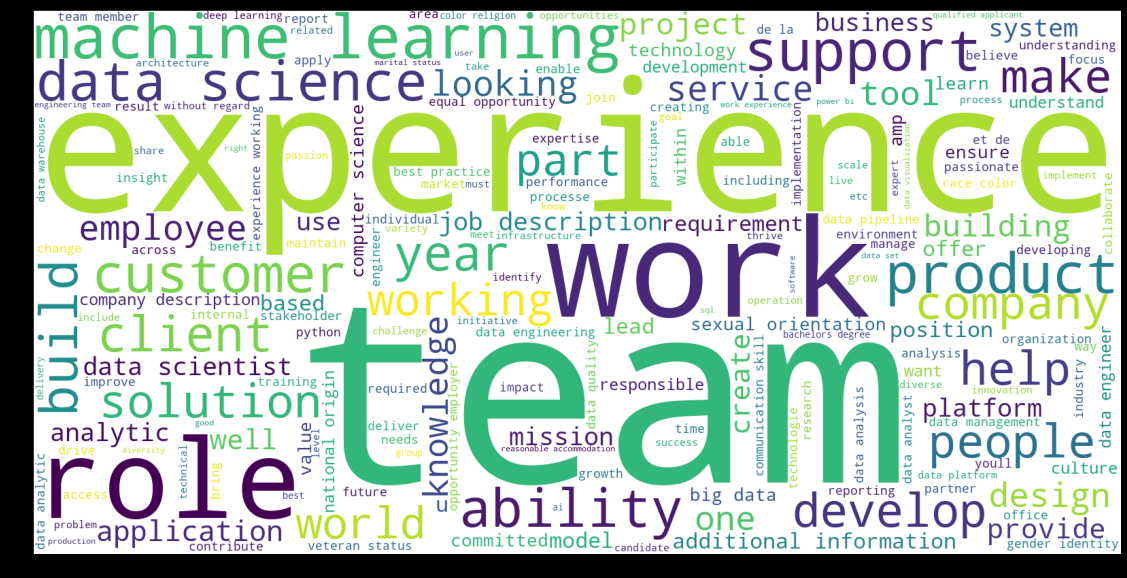

In [10]:
## flatten list of lists into singular list of words
words_flat = [item for sublist in words for item in sublist]

## add default exclusion words, plus custom words
stop_words = list(WordCloud().stopwords)
custom_stop_words = ['day', 'need', 'will']
stop_words = set(stop_words + custom_stop_words)

## generate wordcloud
wordcloud = WordCloud(background_color="white",
                      width=1600,height=800, 
                      stopwords=stop_words
                     ).generate(' '.join(words_flat))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [11]:
## remove exclusion words from list
words_clean = [i for i in words_flat if i not in stop_words]

# count frequency of each word
word_freq = Counter(words_clean)
sorted(word_freq.items(), key=lambda x:x[1], reverse=True)[0:30]

[('data', 42113),
 ('experience', 18751),
 ('work', 12833),
 ('de', 12442),
 ('team', 11963),
 ('business', 10571),
 ('et', 6588),
 ('working', 6513),
 ('solutions', 6409),
 ('learning', 6379),
 ('skills', 6242),
 ('company', 6195),
 ('development', 5394),
 ('analytics', 5223),
 ('&amp', 5175),
 ('us', 5077),
 ('science', 4950),
 ('role', 4703),
 ('new', 4640),
 ('teams', 4590),
 ('engineering', 4589),
 ('product', 4588),
 ('years', 4346),
 ('des', 4334),
 ('knowledge', 4277),
 ('information', 4250),
 ('machine', 4236),
 ('including', 4216),
 ('people', 4216),
 ('support', 4215)]

In [15]:
df.to_csv('data/aiJobsDf.csv')

In [17]:
pd.Series(words_clean).to_csv('data/aiJobsWords.csv')